# 5. Capstone Project: Data Preparation II

***

![headerall](./images/headers/header_all.jpg)

##  Goals

### Project:
In this work, we will first analyze where and when traffic congestion is highest and lowest in New York State. We will then build different machine learning models capable of predicting cab travel times in and around New York City using only variables that can be easily obtained from a smartphone app or a website. We will then compare their performance and explore the possibility of using additional variables such as weather forecasts and holidays to improve the predictive performance of the models.

### Section:
In this section, data will be prepared for the next steps, i.e., exploratory data analysis and machine learning model building. First, we will collect and import the necessary datasets. Next, we will review each of these datasets to fully understand the data and its structure, including the different variables available, their format, and their relevance to the project. Finally, we will perform data cleaning and manipulation, as well as feature engineering, and encoding.

The data preparation will be divided into two subsections, the first dedicated to the external datasets (Data Preparation Part I) and the second to the New York City Taxi Trip data set (Data Preparation Part II). Finally, external datasets will be merged with the primary one.

## Data
### External Datasets:
- Weather Forecast: The 2018 NYC weather forecast was collected from the [National Weather Service Forecast Office](https://w2.weather.gov/climate/index.php?wfo=okx) website. Daily measurements were taken from January to December 2018 in Central Park. These measures are given in imperial units and include daily minimum and maximum temperatures, precipitations, snowfall, and snow depth.

- Holidays: The 2018 NYC holidays list was collected from the [Office Holiday](https://www.officeholidays.com/countries/usa/new-york/2021) website. The dataset contains the name, date, and type of holidays for New York.

- Taxi Zones: The NYC Taxi Zones dataset was collected from the [NYC Open Data](https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc) website. It contains the pickup and drop-off zones (Location IDs) for the Yellow, Green, and FHV Trip Records. The taxi zones are based on the NYC Department of City Planning’s Neighborhood.

### Primary Datasets:

- Taxi Trips: The 2018 NYC Taxi Trip dataset was collected from the [Google Big Query](https://console.cloud.google.com/marketplace/product/city-of-new-york/nyc-tlc-trips?project=jovial-monument-300209&folder=&organizationId=) platform. The dataset contains more than 100'000'000 Yellow Taxi Trip records for 2018 and contains an extensive amount of variables including the pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

***
## Table of Content:
    1. Data Preparation
        1.1 External Datasets
            1.1.1 Weather Forecast Dataset
            1.1.2 Holidays Dataset
            1.1.3 Taxi Zones Dataset
        1.2 Primary Dataset
            1.2.1 Taxi Trips Dataset
            1.2.2 Taxi Trips Subset
    2. Exploratory Data Analysis
        2.1 Primary Dataset
            2.1.1 Temporal Analysis
            2.1.2 Spatio-Temporal Analysis
        2.2 External Datasets
            2.2.1 Temporal Analysis of Weather Data
            2.2.2 Temporal Analysis of Holidays Data
        2.3 Combined Dataset
            2.3.1 Overall Features Correlation
    3. Machine Learning Models

***
## Python Libraries and Magic commands Import

In [1]:
# Import python core libraries
import os

# Import data processing libraries
import pandas as pd
import numpy as np

# Import Visualization librairies
import matplotlib.pyplot as plt
import seaborn as sns

# Import machine learning libraries
from sklearn.model_selection import train_test_split

In [2]:
# Set up magic commands
%matplotlib inline
%config Completer.use_jedi = False

***
## Data Import

In [3]:
# Import the weather forecasts dataset
weather_df = pd.read_pickle(r'data/processed/weather.pickle')

# Import the holidays dataset
holidays_df = pd.read_pickle(r'data/processed/holidays.pickle')

# Import the zones dataset
zones_df = pd.read_pickle(r'data/processed/zones.pickle')

***
## Functions import

In [4]:
# Define a function that downloads a percentage of the whole 2018 taxi trips records dataset
def download_dataset(frac=0.01):

    # Create a global variable containing the credentials to query Google Big Query Servers
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"credentials\exts-ml-5e5656f1d391.json"

    # Create an empty data frame
    records_df = pd.DataFrame()

    # Create a row offest
    row_offset = 0

    # Create a row limit
    row_limit = 10000000

    # Create a row offest counter
    row_counter = 10000000

    # Get the NYC taxi dataset in chuncks of 10M to avoid insufficient memory issues
    while row_counter == row_limit:

        print(f"Fetching rows from {row_offset} to {row_offset + row_counter}:")

        # Create a query to fetch and transform the NYC taxi dataset from the Google Big Query servers
        query = f"""
         SELECT
             pickup_datetime,
             dropoff_datetime,
             passenger_count,
             trip_distance,
             tolls_amount,
             fare_amount,
             pickup_location_id,
             dropoff_location_id,
             TIMESTAMP_DIFF(TIMESTAMP(dropoff_datetime), TIMESTAMP(pickup_datetime), MINUTE) as trip_duration
         FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018`
         LIMIT {row_limit}
         OFFSET {row_offset};
         """
        # Get a chunck of the Google Big Query servers
        df = pd.read_gbq(
            query, project_id="exts-ml", dialect="standard", progress_bar_type="tqdm"
        )

        # Get a random sample of 1% of the NYC taxi dataset chunck
        records_df = records_df.append(
            df.sample(frac=frac, replace=False, random_state=0), ignore_index=True
        )

        # Update the row counter with the current data frame lenght
        row_counter = len(df.index)

        # Update the row offest
        row_offset += row_counter

    # Return the data frame
    return records_df

In [5]:
# Define a function that transform column headers to titles
def to_title(data, sep='_'):
    return [s.replace(sep, ' ').title() for s in data]

In [6]:
# Define a function that compute and display descriptive statistics for selected columns
def show_distribution(data, columns, statistics, percentiles):

    # Create an empty dictionnary to collect the columns' descriptive statistics
    frame = {}

    # Iterate over the given numerical columns
    for column in columns:

        # Compute the descriptive statistics for records above the column's given percentile
        output = (
            data.loc[data[column] > percentiles[column].iloc[0], column]
            .describe()[statistics]
            .round(2)
        )

        # Add the column's descriptive statistics to the dictionnary
        frame[column] = output

    # Return the columns' descriptive statistics as a data frame
    return pd.DataFrame(frame)

In [7]:
# Define a function that remove outliers from a data frame using a percentile table
def remove_outliers(df, prc):
    # Discards records with passenger counts above the 95th percentile and below or equal to 0
    df = df.loc[
        (df['passenger_count'] <= prc['passenger_count'].iloc[1])
        & (df['passenger_count'] > 0)
    ]

    # Discards records with toll amounts above the 99th percentile and below or equal to 0
    df = df.loc[
        (df['trip_distance'] <= prc['trip_distance'].iloc[2])
        & (df['trip_distance'] > 0)
    ]

    # Discards records with tolls amounts above the 99th percentile and below 0
    df = df.loc[
        (df['tolls_amount'] <= prc['tolls_amount'].iloc[2])
        & (df['trip_distance'] >= 0)
    ]

    # Discards records with fare amounts above the 99th percentile and below 0
    df = df.loc[
        (df['fare_amount'] <= prc['fare_amount'].iloc[2])
        & (df['fare_amount'] > 0)
    ]

    # Discards records with trip duration above the 99 percentile and below 1
    df = df.loc[
        (df['trip_duration'] <= prc['trip_duration'].iloc[2])
        & (df['trip_duration'] > 1)
    ]
    
    # Return the data frame
    return df

In [8]:
def add_features(df):
    # Add a new column containing the date
    df["pickup_date"] = pd.to_datetime(df["pickup_datetime"].dt.date)

    # Add a new column containing the month of the year
    df["pickup_month"] = df["pickup_datetime"].dt.month

    # Add a new column containing the week of the year
    df["pickup_week"] = df["pickup_datetime"].dt.isocalendar().week

    # Add a new column containing the day of the year
    df["pickup_yearday"] = df["pickup_datetime"].dt.dayofyear

    # Add a new column containing the weekday of the week
    df["pickup_weekday"] = df["pickup_datetime"].dt.weekday

    # Add a new column containing the type of weekday (week=0, weekend=1)
    df["pickup_weekday_type"] = np.where(df["pickup_weekday"] < 5, 0, 1)

    # Add a new column containing the hour of the day
    df["pickup_hour"] = df["pickup_datetime"].dt.hour

    # Add a new column containing the type of hour (night=0, day=1)
    df["pickup_hour_type"] = np.where(
        (df["pickup_hour"] < 6) | (df["pickup_hour"] > 21), 0, 1
    )
    
    # Return the data frame
    return df

In [9]:
def add_datasets(df, weather_df, holidays_df, zones_df):

    # Define zones columns to be merged with the train dataset
    zones_columns = [
        "OBJECTID",
        "BoroughID",
        "zone_latitude",
        "zone_longitude",
        "borough_latitude",
        "borough_longitude",
    ]

    # Add the weather forecast dataset
    df = pd.merge(
        df,
        weather_df,
        how="left",
        left_on="pickup_date",
        right_on="date",
    )

    # Add the holidays dataset
    df = pd.merge(
        df,
        holidays_df,
        how="left",
        left_on="pickup_date",
        right_on="holiday_date",
    )

    # Add the zones dataset (pickup)
    df = (
        pd.merge(
            df,
            zones_df[zones_columns],
            how="left",
            left_on="pickup_location_id",
            right_on="OBJECTID",
        )
        .rename(columns={"BoroughID": "pickup_borough_id"})
        .rename(columns=dict(zip(zones_columns[-4:], ["pickup_" + s for s in zones_columns[-4:]])))
        .drop("OBJECTID", axis="columns")
    )

    # Add the zone dataset (dropff)
    df = (
        pd.merge(
            df,
            zones_df[zones_columns],
            how="left",
            left_on="dropoff_location_id",
            right_on="OBJECTID",
        )
        .rename(columns={"BoroughID": "dropoff_borough_id"})
        .rename(columns=dict(zip(zones_columns[-4:], ["dropoff_" + s for s in zones_columns[-4:]])))
        .drop("OBJECTID", axis="columns")
    )

    # Drop datetime columns
    df.drop(columns=df.select_dtypes(include=["datetime64"]), inplace=True)

    # Return the data frame
    return df

In [10]:
# Define a function that display scatter plots of selected numerical columns
def plot_scatter(data, columns, colnames, variable, ncols=1, nrows=1, color="C0"):

    varname = variable.replace("_", " ").title()

    # Create a figure with n columns and rows
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, sharey=True, figsize=(ncols * 5, nrows * 5)
    )

    # Flatten axes for 2D figures
    if ncols > 1 or nrows > 1:
        axes = axes.ravel()

    # Generate the plots
    for ax, col, colname in zip(axes, columns, colnames):
        sns.scatterplot(x=col, y=variable, data=data, ax=ax, s=10, color=color)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.set_ylim(0)
        ax.tick_params(labelsize=14)
        ax.set_xlabel(colname, fontsize=14)
        ax.set_ylabel(varname, fontsize=14)
        ax.set_title(f"{varname} vs {colname}", fontsize=16)
        ax.grid()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)

    # Display the figure
    plt.show()

In [11]:
# Define a function that display scatter plots of selected numerical columns
def plot_histplot(data, columns, colnames, ncols=1, nrows=1, color="C0"):

    # Create a figure with n columns and rows
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, sharey=True, figsize=(ncols * 5, nrows * 5)
    )

    # Flatten axes for 2D figures
    if ncols > 1 or nrows > 1:
        axes = axes.ravel()

    # Generate the plots
    for ax, col, colname in zip(axes, columns, colnames):
        sns.histplot(
            x=col, bins=20, data=data, ax=ax, color=color, edgecolor="white", alpha=0.7
        )
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.tick_params(labelsize=14)
        ax.set_xlabel(colname, fontsize=14)
        ax.set_ylabel("Count", fontsize=14)
        ax.set_title(colname, fontsize=16)
        ax.grid()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)

    # Display the figure
    plt.show()

In [12]:
# Define a function that display individual boxplot of selected numerical columns
def plot_boxplot(data, columns, colnames, ncols=1, nrows=1, color="C0"):
    # Create a figure with n columns and rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))

    # Flatten axes for 2D figures
    if ncols > 1 or nrows > 1:
        axes = axes.ravel()

    # Generate the plots
    for ax, col, colname in zip(axes, columns, colnames):
        sns.boxplot(
            y=col,
            data=data,
            ax=ax,
            width=0.35,
            linewidth=1,
            color=color,
            boxprops=dict(alpha=0.7),
        )
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_ticks_position("none")
        ax.xaxis.set_ticks([])
        ax.tick_params(labelsize=14)
        ax.set_xlabel(colname, fontsize=14)
        ax.set_ylabel(None)
        ax.set_title(colname, fontsize=16)
        ax.grid()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)

    # Display the figure
    plt.show()

In [13]:
# Define a function that display individual violinplot of selected numerical columns
def plot_violinplot(data, columns, colnames, ncols=1, nrows=1, color="C0"):

    # Create a figure with n columns and rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))

    # Flatten axes for 2D figures
    if ncols > 1 or nrows > 1:
        axes = axes.ravel()

    # Generate the plots
    for ax, col, colname in zip(axes, columns, colnames):
        violin_plot = ax.violinplot(data[col])

        # Change color of the violin plot
        for pc in violin_plot["bodies"]:
            pc.set_facecolor(color)
            pc.set_edgecolor(color)

        violin_plot["cbars"].set_edgecolor("black")
        violin_plot["cmins"].set_edgecolor("black")
        violin_plot["cmaxes"].set_edgecolor("black")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_ticks_position("none")
        ax.tick_params(labelsize=14)
        ax.set_title(colname, fontsize=16)
        ax.grid()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)

    # Display the figure
    plt.show()

***
# 1. Data Preparation
## 1.2 Data Preparation: Taxi Trips Dataset

### Goals:

Get a subset (1%) of the 2018 NYC yellow taxi trip dataset and perform data cleaning and manipulation, as well as feature engineering, binning and encoding if needed.

### Code:

In [14]:
# Download the dataset (uncomment if needed)
# records_df = download_dataset()

# Export the dataset as a pickle file (uncomment if needed)
# records_df.to_pickle(r'data/raw/taxi_records.pickle')

In [15]:
# Download the dataset (if)

# Open data frame
records_df = pd.read_pickle('data/raw/taxi_records_v1.pickle')

records_df['trip_duration'] = (
   records_df.dropoff_datetime - records_df.pickup_datetime
).dt.seconds / 60

records_df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,tolls_amount,fare_amount,pickup_location_id,dropoff_location_id,trip_duration
0,2018-04-26 12:11:19,2018-04-26 12:24:34,3,8.90,2.64,25.0,143,220,13.250000
1,2018-06-19 10:02:34,2018-06-19 10:45:46,1,15.84,0.00,48.0,138,85,43.200000
2,2018-09-05 13:51:40,2018-09-05 14:33:07,1,11.10,5.76,37.5,138,142,41.450000
3,2018-05-11 10:20:58,2018-05-11 10:46:27,2,8.49,0.00,27.5,45,41,25.483333
4,2018-12-16 18:21:08,2018-12-16 18:46:04,6,7.79,0.00,24.5,229,106,24.933333


In [16]:
# Display a quick description of the data frame
records_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122346 entries, 0 to 1122345
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   pickup_datetime      1122346 non-null  datetime64[ns]
 1   dropoff_datetime     1122346 non-null  datetime64[ns]
 2   passenger_count      1122346 non-null  int64         
 3   trip_distance        1122346 non-null  float64       
 4   tolls_amount         1122346 non-null  float64       
 5   fare_amount          1122346 non-null  float64       
 6   pickup_location_id   1122346 non-null  category      
 7   dropoff_location_id  1122346 non-null  category      
 8   trip_duration        1122346 non-null  float64       
dtypes: category(2), datetime64[ns](2), float64(4), int64(1)
memory usage: 64.2 MB


**Notes:** the data frame contains 1% of all 2018 NYC cab fare records, totaling 1,122,346 data points. Most of the numeric columns are the wrong type and will be converted from string (Object) to float or integer. Trip distance will be converted from miles to kilometers. Columns may also contain null values, and since most machine learning algorithms cannot properly process them, we will first need to check that each column does not contain any before continuing with data cleaning and feature engineering/coding.

In [17]:
# Define numerical columns to be converted to float
float_columns = ["trip_distance", "tolls_amount", "fare_amount", "trip_duration"]

# Convert numerical columns to float
records_df[float_columns] = records_df[float_columns].astype("float64")

# Define numerical columns to be converted to int 
int_columns = ["pickup_location_id", "dropoff_location_id"]

# Convert numerical columns to int
records_df[int_columns] = records_df[int_columns].astype('int64')

# Convert the trip distance from miles to kilometers
records_df["trip_distance"] = np.multiply(records_df["trip_distance"], 1.60934)

# Display a quick description of the data frame
records_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122346 entries, 0 to 1122345
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   pickup_datetime      1122346 non-null  datetime64[ns]
 1   dropoff_datetime     1122346 non-null  datetime64[ns]
 2   passenger_count      1122346 non-null  int64         
 3   trip_distance        1122346 non-null  float64       
 4   tolls_amount         1122346 non-null  float64       
 5   fare_amount          1122346 non-null  float64       
 6   pickup_location_id   1122346 non-null  int64         
 7   dropoff_location_id  1122346 non-null  int64         
 8   trip_duration        1122346 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(3)
memory usage: 77.1 MB


**Notes:** The dataset has no missing values and each column has been correctly formatted. We can now split the data set into a training set and a test set (80/20).

In [18]:
# Split the dataset into a train and test data frame
train_df, test_df = train_test_split(records_df, test_size=0.2, random_state=0)

print(f" Train data frame shape: {train_df.shape}")
print(f" Test data frame shape: {test_df.shape}")

 Train data frame shape: (897876, 9)
 Test data frame shape: (224470, 9)


**Notes:** the dataset has been divided into 80-20 train and test set, each containing 21 columns.

### Taxi Trips Dataset: Data cleaning
The dataset may contain erroneous values as well as outliers. We will start by checking that the date columns do not contain records before or after 2018.

In [19]:
# Display the records with pickup dates out of the date range (2018.01.01 - 2018.01.01)
train_df[
    (train_df['pickup_datetime'] < '2018.01.01')
    | (train_df['pickup_datetime'] > '2019.01.01')
]

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,tolls_amount,fare_amount,pickup_location_id,dropoff_location_id,trip_duration
520400,2009-01-01 01:11:08,2009-01-01 01:36:14,1,5.471756,0.0,17.0,125,161,25.100000
543657,2017-12-31 18:01:08,2017-12-31 18:19:43,2,6.389080,0.0,15.5,43,107,18.583333
603289,2009-01-01 00:08:34,2009-01-01 00:18:41,1,2.430103,0.0,8.0,236,239,10.116667
377679,2009-01-01 00:03:46,2009-01-01 00:07:09,2,0.000000,0.0,4.0,193,193,3.383333
384671,2019-02-13 06:20:00,2019-02-13 06:29:04,6,2.446197,0.0,8.0,186,137,9.066667
232220,2009-01-01 00:02:33,2009-01-01 00:11:27,1,1.303565,0.0,6.5,163,230,8.900000
796709,2008-12-31 09:42:18,2008-12-31 09:55:18,2,2.430103,0.0,10.0,79,45,13.000000
88284,2009-01-01 19:00:20,2009-01-01 19:31:20,1,20.486898,0.0,36.5,138,132,31.000000
47651,2008-12-31 23:04:03,2008-12-31 23:52:46,3,8.159354,0.0,30.5,262,43,48.716667
836528,2008-12-31 08:12:36,2008-12-31 08:18:36,1,1.094351,0.0,5.5,263,75,6.000000


**Notes:** over a dozen records date from before or after 2018 in the train dataset. These records will be removed from the dataset.

In [20]:
# Remove records with pickup dates below 2018.01.01 and above 2018.01.01
train_df = train_df[
    (train_df['pickup_datetime'] >= '2018.01.01')
    & (train_df['pickup_datetime'] <= '2019.01.01')
]

# Remove records with pickup dates below 2018.01.01 and above 2018.01.01
test_df = test_df[
    (test_df['pickup_datetime'] >= '2018.01.01')
    & (test_df['pickup_datetime'] <= '2019.01.01')
]

**Notes:** records with dates out of range were removed from both dataset.

In [21]:
# Display some descriptive statistics
train_df.describe().round(2)

,passenger_count,trip_distance,tolls_amount,fare_amount,pickup_location_id,dropoff_location_id,trip_duration
count,897863.00,897863.00,897863.00,897863.00,897863.00,897863.00,897863.00
mean,1.60,4.64,0.34,13.07,163.24,161.51,17.23
std,1.24,5.98,1.65,211.57,66.39,70.34,66.03
min,0.00,0.00,-18.00,-275.00,1.00,1.00,0.00
25%,1.00,1.54,0.00,6.50,114.00,107.00,6.58
50%,1.00,2.57,0.00,9.00,162.00,162.00,10.95
75%,2.00,4.72,0.00,14.50,233.00,233.00,18.08
max,9.00,132.64,576.00,200005.50,265.00,265.00,1439.97


**Notes:** pickup and drop-off location columns contain more than the 263 zones. Locations 264 and 265 are used as surrogates when the origin or destination of trips is unknown. Therefore, we can safely eliminate these records from the dataset.

In [22]:
# Discards records with erroneous pickup and droppoff zones
train_df =  train_df[(train_df["pickup_location_id"] <= 263) & (train_df["dropoff_location_id"] <= 263)]

# Discards records with erroneous pickup and droppoff zones
test_df =  test_df[(test_df["pickup_location_id"] <= 263) & (test_df["dropoff_location_id"] <= 263)]

# Display some descriptive statistics
train_df.describe().round(2)

,passenger_count,trip_distance,tolls_amount,fare_amount,pickup_location_id,dropoff_location_id,trip_duration
count,880614.00,880614.00,880614.00,880614.00,880614.00,880614.00,880614.00
mean,1.60,4.60,0.32,12.92,161.63,159.81,17.22
std,1.25,5.84,1.58,213.58,65.68,69.66,66.00
min,0.00,0.00,-11.75,-79.00,1.00,1.00,0.00
25%,1.00,1.54,0.00,6.50,114.00,107.00,6.60
50%,1.00,2.57,0.00,9.00,161.00,162.00,10.95
75%,2.00,4.70,0.00,14.50,231.00,233.00,18.05
max,9.00,129.36,576.00,200005.50,263.00,263.00,1439.97


**Notes:** records with unknown origins and destinations have been removed from the dataset, but most numerical columns contain extreme and erroneous values. For instance, according to the [official NYC Taxi](https://www1.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page) website, the maximum number of passengers allowed by law in a yellow taxi is four in a four-passenger taxi or five in a five-passenger taxi. Therefore, trips with more than five passengers are either errors or the result of taxi drivers picking up additional passengers en route to their final destination. Some records have negative, null or extreme values the number of passenger, distance traveled, toll amount and fare amount. Taxi trip records with null, extreme or erroneous values will be removed from the dataset.

In [23]:
# Define the name of numerical columns
num_cols = [
    'passenger_count',
    'trip_distance',
    'tolls_amount',
    'fare_amount',
    'trip_duration',
]

# Define the name of numerical columns
num_colnames = to_title(num_cols)

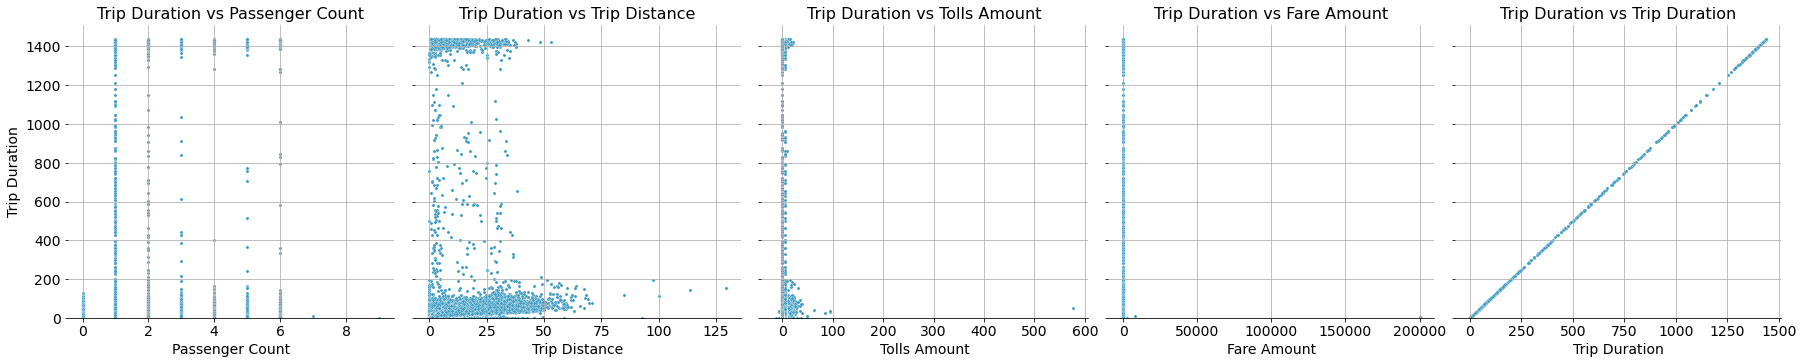

In [24]:
# Display scatterplot of numerical columns
plot_scatter(
    train_df,
    num_cols,
    num_colnames,
    "trip_duration",
    ncols=len(num_cols),
    color="#3999C1",
)

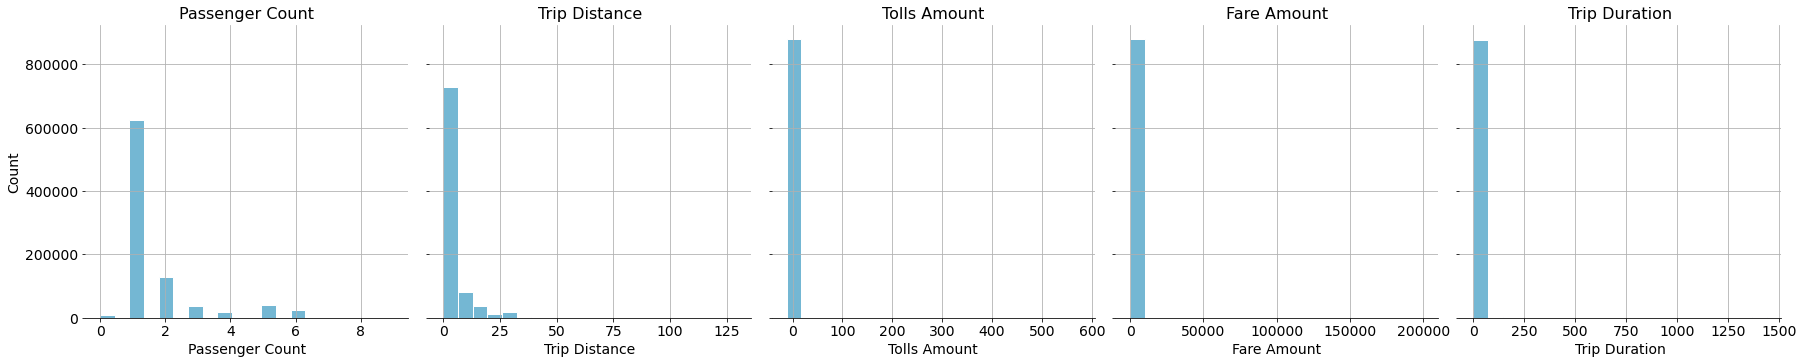

In [25]:
# Display histograms of numerical columns
plot_histplot(
    train_df,
    num_cols,
    num_colnames,
    ncols=len(num_cols),
    color="#3999C1",
)

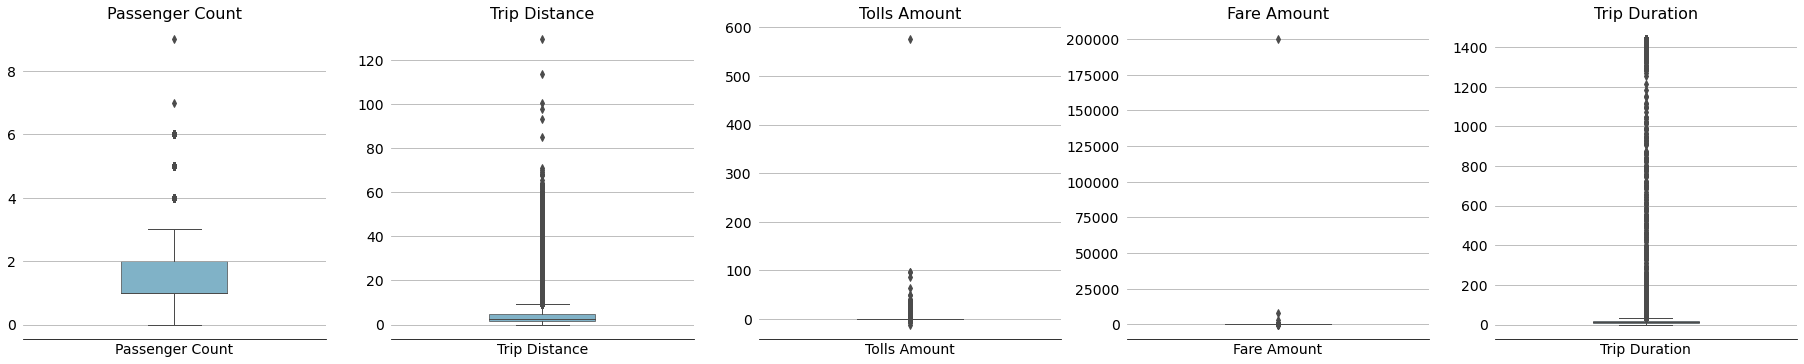

In [26]:
# Display boxplots of numerical columns
plot_boxplot(
    train_df,
    num_cols,
    num_colnames,
    ncols=len(num_cols),
    color="#3999C1",
)

**Notes:** The distribution of variables such as number of passengers, distance traveled, toll amount, trip amount, and trip duration is heavily skewed by the presence of many near-zero values and outliers. We will not eliminate the near-zero values because they correspond to real and frequent trips, but we will eliminate most of the outliers while trying to preserve some degree of variability so that our models can correctly estimate the duration of non-conventional taxi trips.

In [27]:
# Compute the numerical columns' 75, 95, and 99th percentiles
percentiles_df = train_df.quantile([0.75, 0.95, 0.99])[num_cols].reset_index()

# Display the numerical columns' 75, 95, and 99th percentiles
percentiles_df

,index,passenger_count,trip_distance,tolls_amount,fare_amount,trip_duration
0,0.75,2.0,4.699273,0.00,14.5,18.050000
1,0.95,5.0,17.059004,5.76,35.5,36.800000
2,0.99,6.0,30.094658,5.76,52.0,61.516667


**Notes:** the table above shows the 75th, 95th, and 99th of numerical variables, including passagenger count, trip distance, tolls and fare amounts, and trip duration.

In [28]:
# Define the descriptive statistics to display
perc_statistics = ['count', 'mean', 'std', 'min', 'max']

# Get the numerical columns' 75th percentiles
perc_75 = percentiles_df[percentiles_df['index'] == 0.75]

# Compute and display descriptive statistics for records above the column's 75th percentile
show_distribution(train_df, num_cols, perc_statistics, perc_75)

,passenger_count,trip_distance,tolls_amount,fare_amount,trip_duration
count,118623.00,219941.00,46638.00,208662.00,220055.00
mean,4.44,11.91,6.13,28.26,41.76
std,1.13,7.87,3.42,438.37,128.73
min,3.00,4.72,0.04,14.70,18.07
max,9.00,129.36,576.00,200005.50,1439.97


**Notes:** the table above shows the descriptive statistics of the numerical variables for records marked as outliers, if the 75th percentile was used as the upper threshold. Depending on the variable, up to one-third of the data set could be didscarded and only the most common taxi trips would be retained.

In [29]:
# Get the numerical columns' 95th percentiles
perc_95 = percentiles_df[percentiles_df['index'] == 0.95]

# Compute and display descriptive statistics for records above the column's 95th percentile
show_distribution(train_df, num_cols, perc_statistics, perc_95)

,passenger_count,trip_distance,tolls_amount,fare_amount,trip_duration
count,24304.00,43640.00,2210.00,43002.00,44014.00
mean,6.00,25.36,14.42,54.06,110.12
std,0.02,6.21,13.11,965.17,277.33
min,6.00,17.08,5.77,35.56,36.82
max,9.00,129.36,576.00,200005.50,1439.97


**Notes:** the table above shows the descriptive statistics of the numerical variables for records marked as outliers, if the 95th percentile was used as the upper threshold. Depending on the variable, up to 7% of the data set could be discarded, but trips diversity would be greater than if the 75th percentile were used. It would also discard taxi trips with more than five passengers. However, for the other variables, using the 95th percentile would lead to the exclusion of long-distance and flat-rate rides, including those between Manhattan and JFK Airport, as reported in the [official NYC FAQ](https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page).

In [30]:
# Get the numerical columns' 99th percentiles
perc_99 = percentiles_df[percentiles_df['index'] == 0.99]

# Compute and display descriptive statistics for records above the column's 99th percentile
show_distribution(train_df, num_cols, perc_statistics, perc_99)

,passenger_count,trip_distance,tolls_amount,fare_amount,trip_duration
count,2.00,8792.00,2210.00,5436.00,8800.00
mean,8.00,34.00,14.42,104.98,368.58
std,1.41,4.88,13.11,2714.23,548.67
min,7.00,30.11,5.77,52.16,61.53
max,9.00,129.36,576.00,200005.50,1439.97


**Notes:** the table above shows the descriptive statistics of the numerical variables for records marked as outliers, if the 99th percentile was used as the upper threshold.  Depending on the variable, up to 1.5% of the data set could be discarded. The diversity of trips would be much greater than if the 75th and 95th percentiles were used. By using the 99th percentile, the most extreme or erroneous trips would be discarded, while retaining a high degree of variability, which would help our predictive model estimate the duration of non-conventional cab trips. We will thus use mostly the 99th and 95th percentil to delete outliers from the data set.

In [31]:
# Remove outliers from the train dataset
train_df = remove_outliers(train_df, percentiles_df)

# Remove outliers from the test dataset
test_df = remove_outliers(test_df, percentiles_df)

**Note:** The 95th percentile was used to discard outliers from the passenger count column, while the 99th percentile was used to discard outliers and erroneous records from all other columns. Approximately 7% of the data set was discarded.

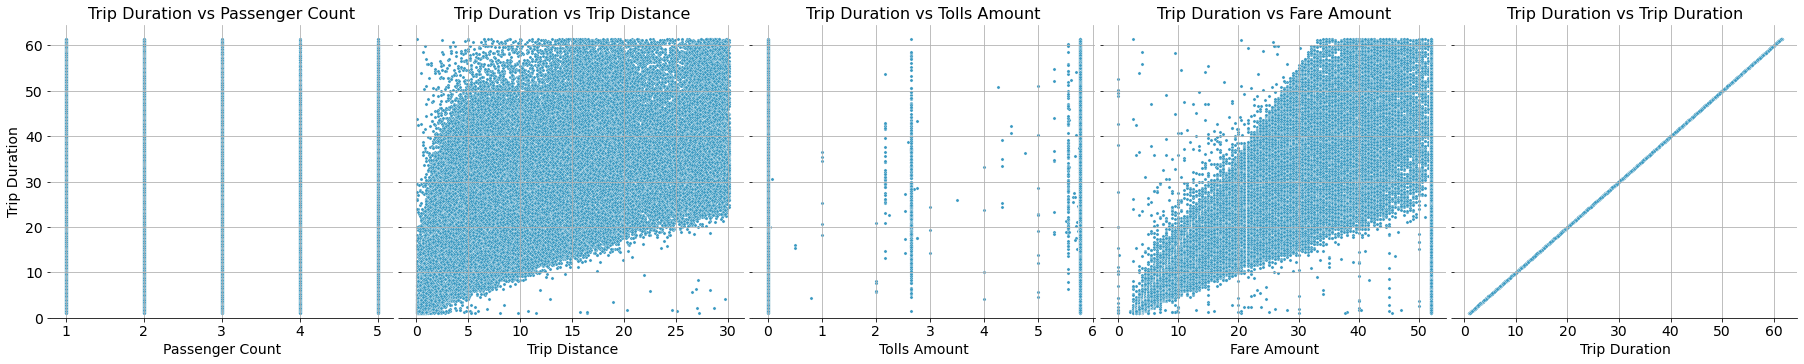

In [32]:
# Display scatterplots of numerical columns
plot_scatter(train_df, num_cols, num_colnames, 'trip_duration', ncols=len(num_cols), color="#3999C1")

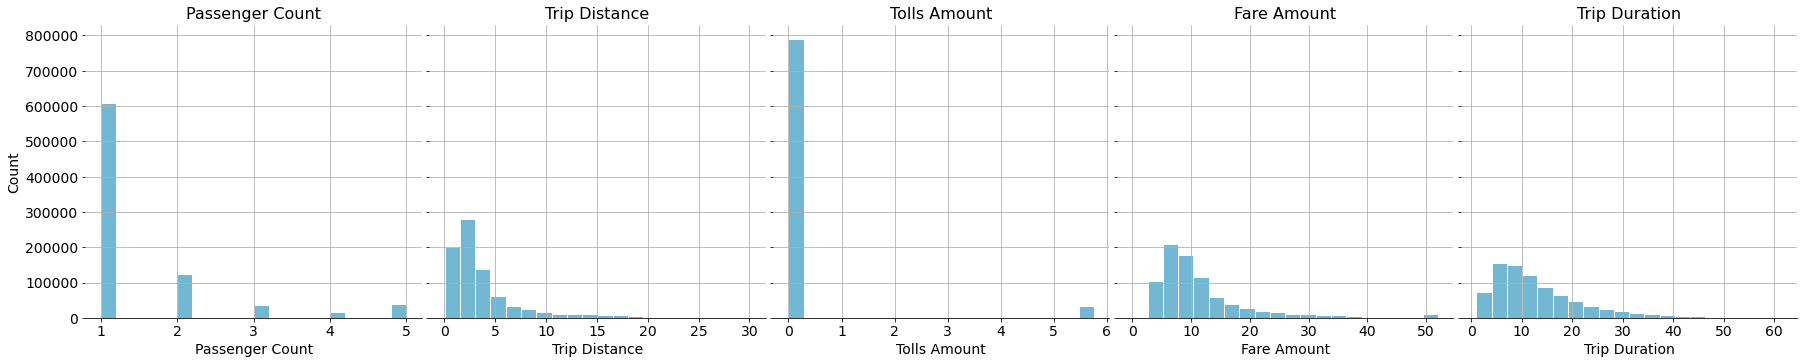

In [33]:
# Display histograms of numerical columns
plot_histplot(train_df, num_cols, num_colnames, ncols=len(num_cols), color="#3999C1")

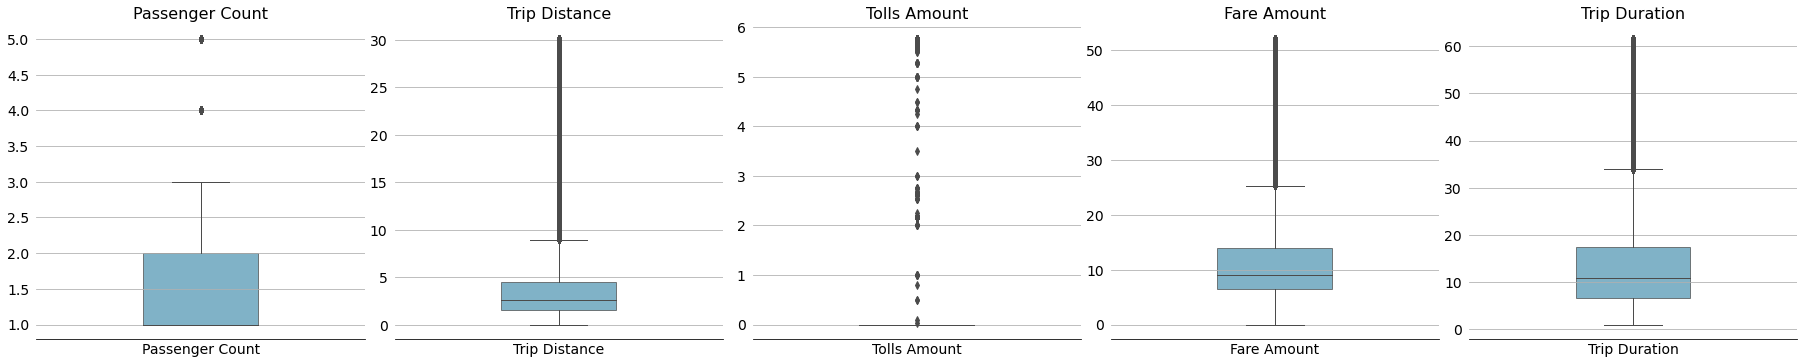

In [34]:
# Display boxplots of numerical columns
plot_boxplot(train_df, num_cols, num_colnames, ncols=len(num_cols), color="#3999C1")

**Notes:** After removing the extreme and spurious values from the data set, we can observe a strong correlation between travel time and distance and fare amount. In addition, each variable has a righ-skewed distribution. Therefore, we will need to log-transfom and normalize the data before using it to train our different models. Below, we will proceed with feature engineering and then encoding, starting with the date and time of pickup.

### Taxi Trips Dataset: Feature Engineering
Dates are usually an excellent source of information that first needs to be transformed into numerical data to be used by machine learning algorithms. Below, we will create a set of new variables from the pickup date and time, including month of the year, day of the year, day of the week, type of day (weekday, weekend), time of day, and peak hours. 

In [35]:
# Add features to the train data frame
train_df = add_features(train_df)

# Add features to the test data frame
test_df = add_features(test_df)

# Display a quick description of the data frame
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824654 entries, 10998 to 305711
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   pickup_datetime      824654 non-null  datetime64[ns]
 1   dropoff_datetime     824654 non-null  datetime64[ns]
 2   passenger_count      824654 non-null  int64         
 3   trip_distance        824654 non-null  float64       
 4   tolls_amount         824654 non-null  float64       
 5   fare_amount          824654 non-null  float64       
 6   pickup_location_id   824654 non-null  int64         
 7   dropoff_location_id  824654 non-null  int64         
 8   trip_duration        824654 non-null  float64       
 9   pickup_date          824654 non-null  datetime64[ns]
 10  pickup_month         824654 non-null  int64         
 11  pickup_week          824654 non-null  UInt32        
 12  pickup_yearday       824654 non-null  int64         
 13  pickup_wee

**Notes:** using on the pickup date and time column, we created seven new variables, including the date, month of year, day of year, day of week, type of day (weekday, weekend), time of day, and peak hours. The time range used for the peak hours was determined using the daily traffic data analysis available on the [tomtom website](https://www.tomtom.com/en_gb/traffic-index/new-york-traffic/). The date column will be used below to merge the weather forecast and holidays data frames with the primary data set.

In [36]:
# Add the external dataset to the train data frame
train_df = add_datasets(train_df, weather_df, holidays_df, zones_df)

# Add the external dataset to the test data frame
test_df = add_datasets(test_df, weather_df, holidays_df, zones_df)

# Display a quick description of the data frame
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824654 entries, 0 to 824653
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   passenger_count            824654 non-null  int64  
 1   trip_distance              824654 non-null  float64
 2   tolls_amount               824654 non-null  float64
 3   fare_amount                824654 non-null  float64
 4   pickup_location_id         824654 non-null  int64  
 5   dropoff_location_id        824654 non-null  int64  
 6   trip_duration              824654 non-null  float64
 7   pickup_month               824654 non-null  int64  
 8   pickup_week                824654 non-null  UInt32 
 9   pickup_yearday             824654 non-null  int64  
 10  pickup_weekday             824654 non-null  int64  
 11  pickup_weekday_type        824654 non-null  int64  
 12  pickup_hour                824654 non-null  int64  
 13  pickup_hour_type           82

**Notes:** after merging the weather and vacation data frame with the primary data set, the NaNs in the vacation and vacation type columns will need to be filled with zeros to indicate no vacations on those days.

In [37]:
# Fill missing values from the train dataset with 0
train_df = train_df.fillna(0)

# Fill missing values from the test dataset with 0
test_df = test_df.fillna(0)

# Display a quick description of the data frame
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824654 entries, 0 to 824653
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   passenger_count            824654 non-null  int64  
 1   trip_distance              824654 non-null  float64
 2   tolls_amount               824654 non-null  float64
 3   fare_amount                824654 non-null  float64
 4   pickup_location_id         824654 non-null  int64  
 5   dropoff_location_id        824654 non-null  int64  
 6   trip_duration              824654 non-null  float64
 7   pickup_month               824654 non-null  int64  
 8   pickup_week                824654 non-null  UInt32 
 9   pickup_yearday             824654 non-null  int64  
 10  pickup_weekday             824654 non-null  int64  
 11  pickup_weekday_type        824654 non-null  int64  
 12  pickup_hour                824654 non-null  int64  
 13  pickup_hour_type           82

**Notes:** null values have been replaced by zeros. We  will create an additional feature, to indicate whether the trip was made within the same borough.

In [38]:
# Create a new column indicating if the trip was within the same borough
train_df["trip_within_borough"] = np.where(
    train_df["pickup_borough_id"] == train_df["dropoff_borough_id"], 1, 0
)

# Create a new column indicating if the trip was within the same borough
test_df["trip_within_borough"] = np.where(
    test_df["pickup_borough_id"] == test_df["dropoff_borough_id"], 1, 0
)

# Display a quick description of the data frame
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824654 entries, 0 to 824653
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   passenger_count            824654 non-null  int64  
 1   trip_distance              824654 non-null  float64
 2   tolls_amount               824654 non-null  float64
 3   fare_amount                824654 non-null  float64
 4   pickup_location_id         824654 non-null  int64  
 5   dropoff_location_id        824654 non-null  int64  
 6   trip_duration              824654 non-null  float64
 7   pickup_month               824654 non-null  int64  
 8   pickup_week                824654 non-null  UInt32 
 9   pickup_yearday             824654 non-null  int64  
 10  pickup_weekday             824654 non-null  int64  
 11  pickup_weekday_type        824654 non-null  int64  
 12  pickup_hour                824654 non-null  int64  
 13  pickup_hour_type           82

### Taxi Trips Dataset: Feature Binning

As discussed earlier, bining continuous variables tends to improve the performance of the model by introducing nonlinearity. We will therefore split the toll amounts into three distinct categories ranging from 0 to 3, with 0 indicating no toll and 3 indicating the highest amount. Finally, we will eliminate features that should not be used by our model for trip duration prediction.

In [39]:
# Create a new column of binned tolls amounts in the train dataset
train_df["tolls_amount"] = train_df["tolls_amount"].apply(
    lambda x: 0 if x == 0 else (1 if x < 3 else 2)
)

# Create a new column of binned tolls amounts in the test dataset
test_df["tolls_amount"] = test_df["tolls_amount"].apply(
    lambda x: 0 if x == 0 else (1 if x < 3 else 2)
)

# Display the first five rows of the data frame
train_df.head()

,passenger_count,trip_distance,tolls_amount,fare_amount,pickup_location_id,dropoff_location_id,trip_duration,pickup_month,pickup_week,pickup_yearday,...,pickup_zone_latitude,pickup_zone_longitude,pickup_borough_latitude,pickup_borough_longitude,dropoff_borough_id,dropoff_zone_latitude,dropoff_zone_longitude,dropoff_borough_latitude,dropoff_borough_longitude,trip_within_borough
0,1,6.115492,0,16.5,144,237,20.400000,12,52,360,...,4.971260e+06,-8.237299e+06,4.979599e+06,-8.233970e+06,3,4.978272e+06,-8.233817e+06,4.979599e+06,-8.233970e+06,1
1,1,2.253076,0,9.0,234,162,11.466667,4,16,108,...,4.974117e+06,-8.236580e+06,4.979599e+06,-8.233970e+06,3,4.976519e+06,-8.234565e+06,4.979599e+06,-8.233970e+06,1
2,2,2.574944,0,8.0,249,231,7.933333,9,39,272,...,4.973270e+06,-8.237962e+06,4.979599e+06,-8.233970e+06,3,4.970802e+06,-8.238519e+06,4.979599e+06,-8.233970e+06,1
3,3,1.255285,0,6.5,43,75,8.200000,7,30,205,...,4.980310e+06,-8.233808e+06,4.979599e+06,-8.233970e+06,3,4.981417e+06,-8.231603e+06,4.979599e+06,-8.233970e+06,1
4,1,3.089933,0,8.5,163,140,8.633333,7,28,194,...,4.977656e+06,-8.235145e+06,4.979599e+06,-8.233970e+06,3,4.977812e+06,-8.232604e+06,4.979599e+06,-8.233970e+06,1


**Notes:** the toll amounts have been correctly classified. We can now delete the unnecessary columns and move on to the next section, i.e. the exploratory data analysis.

In [40]:
# Drop other columns from the train data frame
train_df.drop(
    columns=["passenger_count", "fare_amount"], inplace=True
)

# Drop other columns from the test data frame
test_df.drop(
    columns=["passenger_count", "fare_amount"], inplace=True
)

# Display a quick description of the data frame
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824654 entries, 0 to 824653
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   trip_distance              824654 non-null  float64
 1   tolls_amount               824654 non-null  int64  
 2   pickup_location_id         824654 non-null  int64  
 3   dropoff_location_id        824654 non-null  int64  
 4   trip_duration              824654 non-null  float64
 5   pickup_month               824654 non-null  int64  
 6   pickup_week                824654 non-null  UInt32 
 7   pickup_yearday             824654 non-null  int64  
 8   pickup_weekday             824654 non-null  int64  
 9   pickup_weekday_type        824654 non-null  int64  
 10  pickup_hour                824654 non-null  int64  
 11  pickup_hour_type           824654 non-null  int64  
 12  avg_temp                   824654 non-null  int64  
 13  prec                       82

***
## 1.2 Data Preparation: Taxi Trips Subset
### Goals:

Get a subset of one of the most frequent NYC yellow taxi trip and perform data cleaning and manipulation, as well as feature engineering, binning and encoding if needed.

### Code:

In [41]:
#
train_df_freq = (
    train_df.groupby(["pickup_location_id", "dropoff_location_id"])
    .agg(
        trip_count=("trip_duration", "size"),
        trip_duration_median=("trip_duration", "median"),
    )
    .sort_values("trip_count", ascending=False)
    .reset_index()
)

#
trip_duration_median = train_df["trip_duration"].median()

#
train_df_freq[
    (train_df_freq["trip_duration_median"] >= np.floor(trip_duration_median))
    & (train_df_freq["trip_duration_median"] <= np.ceil(trip_duration_median))
].head()

,pickup_location_id,dropoff_location_id,trip_count,trip_duration_median
12,186,161,2000,10.800000
14,186,230,1942,10.183333
28,186,170,1586,10.191667
32,161,234,1547,10.566667
77,162,236,1251,10.333333


**Notes:** Penn Station/Madison sq West to midtown Center

In [42]:
# Create a global variable containing the credentials to query Google Big Query Servers
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"credentials\exts-ml-5e5656f1d391.json"

# Create an empty data frame
records_sub_df = pd.DataFrame()

# Create a row offest
row_offset = 0

# Create a row limit
row_limit = 10000000

# Create a row offest counter
row_counter = 10000000

# Get the NYC taxi dataset in chuncks of 10M to avoid insufficient memory issues
while row_counter == row_limit:

    print(f"Fetching rows from {row_offset} to {row_offset + row_counter}:")

    # Create a query to fetch and transform the NYC taxi dataset from the Google Big Query servers
    query = f"""
        SELECT
            pickup_datetime,
            dropoff_datetime,
            passenger_count,
            trip_distance,
            tolls_amount,
            fare_amount,
            pickup_location_id,
            dropoff_location_id,
            TIMESTAMP_DIFF(TIMESTAMP(dropoff_datetime), TIMESTAMP(pickup_datetime), MINUTE) as trip_duration
        FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018`
        WHERE pickup_location_id = '186' AND dropoff_location_id = '161'
        LIMIT {row_limit}
        OFFSET {row_offset};
     """
    # Get a chunck of the Google Big Query servers
    df = pd.read_gbq(
        query, project_id="exts-ml", dialect="standard", progress_bar_type="tqdm"
    )

    # Get a random sample of 1% of the NYC taxi dataset chunck
    records_sub_df = records_sub_df.append(
        df, ignore_index=True
    )

    # Update the row counter with the current data frame lenght
    row_counter = len(df.index)

    # Update the row offest
    row_offset += row_counter
    
# Display the first five rows of the data frame
records_sub_df.head()

Fetching rows from 0 to 10000000:


Downloading: 100%|█████████| 251506/251506 [00:33<00:00, 7557.19rows/s]


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,tolls_amount,fare_amount,pickup_location_id,dropoff_location_id,trip_duration
0,2018-12-01 17:12:16,2018-12-01 17:54:58,5,1.430000000,0E-9,24.000000000,186,161,42
1,2018-05-16 13:52:18,2018-05-16 14:29:05,1,2.200000000,0E-9,21.500000000,186,161,36
2,2018-12-12 15:22:36,2018-12-12 16:02:34,2,1.770000000,0E-9,22.500000000,186,161,39
3,2018-02-09 10:00:33,2018-02-09 10:38:23,1,2.700000000,0E-9,22.500000000,186,161,37
4,2018-06-07 12:13:41,2018-06-07 12:53:18,4,1.600000000,0E-9,22.000000000,186,161,39


In [43]:
records_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251506 entries, 0 to 251505
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   pickup_datetime      251506 non-null  datetime64[ns]
 1   dropoff_datetime     251506 non-null  datetime64[ns]
 2   passenger_count      251506 non-null  int64         
 3   trip_distance        251506 non-null  object        
 4   tolls_amount         251506 non-null  object        
 5   fare_amount          251506 non-null  object        
 6   pickup_location_id   251506 non-null  object        
 7   dropoff_location_id  251506 non-null  object        
 8   trip_duration        251506 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 17.3+ MB


**Notes:** the data frame contains a total of 251506 records. Most of the numeric columns are the wrong type and will be converted from string (Object) to float or integer. Trip distance will be converted from miles to kilometers. Columns may also contain null values, and since most machine learning algorithms cannot properly process them, we will first need to check that each column does not contain any before continuing with data cleaning and feature engineering/coding.

In [44]:
# Define numerical columns to be converted to float
float_columns = ["trip_distance", "tolls_amount", "fare_amount", "trip_duration"]

# Convert numerical columns to float
records_sub_df[float_columns] = records_sub_df[float_columns].astype("float64")

# Define numerical columns to be converted to int 
int_columns = ["pickup_location_id", "dropoff_location_id"]

# Convert numerical columns to int
records_sub_df[int_columns] = records_sub_df[int_columns].astype('int64')

# Convert the trip distance from miles to kilometers
records_sub_df["trip_distance"] = np.multiply(records_sub_df["trip_distance"], 1.60934)

# Display a quick description of the data frame
records_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251506 entries, 0 to 251505
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   pickup_datetime      251506 non-null  datetime64[ns]
 1   dropoff_datetime     251506 non-null  datetime64[ns]
 2   passenger_count      251506 non-null  int64         
 3   trip_distance        251506 non-null  float64       
 4   tolls_amount         251506 non-null  float64       
 5   fare_amount          251506 non-null  float64       
 6   pickup_location_id   251506 non-null  int64         
 7   dropoff_location_id  251506 non-null  int64         
 8   trip_duration        251506 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(3)
memory usage: 17.3 MB


**Notes:** The dataset has no missing values and each column has been correctly formatted. We can now split the data set into a training set and a test set (80/20).

In [45]:
# Split the dataset into a train and test data frame
train_sub_df, test_sub_df = train_test_split(records_sub_df, test_size=0.2, random_state=0)

print(f" Train data frame shape: {train_sub_df.shape}")
print(f" Test data frame shape: {test_sub_df.shape}")

 Train data frame shape: (201204, 9)
 Test data frame shape: (50302, 9)


**Notes:** the dataset has been divided into 80-20 train and test set, each containing 21 columns. The date columns will first be checked for erroneous records dated before or after 2018.

### Taxi Trips Subset: Data Cleaning
The dataset may contain erroneous values as well as outliers. We will start by checking that the date columns do not contain records before or after 2018.

In [47]:
# Remove records with pickup dates below 2018.01.01 and above 2018.01.01
train_sub_df = train_sub_df[
    (train_sub_df['pickup_datetime'] >= '2018.01.01')
    & (train_sub_df['pickup_datetime'] <= '2019.01.01')
]

# Remove records with pickup dates below 2018.01.01 and above 2018.01.01
test_sub_df = test_sub_df[
    (test_sub_df['pickup_datetime'] >= '2018.01.01')
    & (test_sub_df['pickup_datetime'] <= '2019.01.01')
]

# Display some descriptive statistics
train_sub_df.describe().round(2)

,passenger_count,trip_distance,tolls_amount,fare_amount,pickup_location_id,dropoff_location_id,trip_duration
count,201204.00,201204.00,201204.00,201204.00,201204.0,201204.0,201204.00
mean,1.57,2.10,0.00,9.28,186.0,161.0,13.10
std,1.24,0.67,0.05,3.25,0.0,0.0,846.85
min,0.00,0.00,0.00,-16.00,186.0,161.0,-378700.00
25%,1.00,1.77,0.00,7.00,186.0,161.0,7.00
50%,1.00,2.09,0.00,8.50,186.0,161.0,10.00
75%,2.00,2.41,0.00,11.00,186.0,161.0,16.00
max,6.00,177.03,8.00,103.50,186.0,161.0,1439.00


In [48]:
# Discards records with erroneous pickup and droppoff zones
train_sub_df =  train_sub_df[(train_sub_df["pickup_location_id"] <= 263) & (train_sub_df["dropoff_location_id"] <= 263)]

# Discards records with erroneous pickup and droppoff zones
test_sub_df =  test_sub_df[(test_sub_df["pickup_location_id"] <= 263) & (test_sub_df["dropoff_location_id"] <= 263)]

**Notes:** records with unknown origins and destinations have been removed from the dataset, but most numerical columns contain extreme and erroneous values. For instance, according to the [official NYC Taxi](https://www1.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page) website, the maximum number of passengers allowed by law in a yellow taxi is four in a four-passenger taxi or five in a five-passenger taxi. Therefore, trips with more than five passengers are either errors or the result of taxi drivers picking up additional passengers en route to their final destination. Some records have negative, null or extreme values the number of passenger, distance traveled, toll amount and fare amount. Taxi trip records with null, extreme or erroneous values will be removed from the dataset.

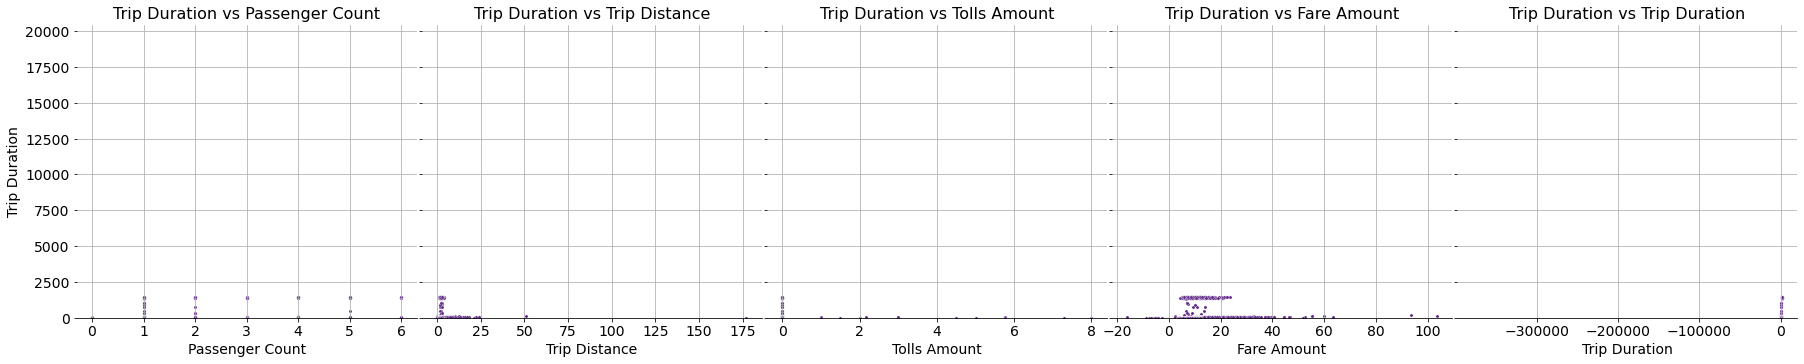

In [49]:
# Display scatterplot of numerical columns
plot_scatter(
    train_sub_df,
    num_cols,
    num_colnames,
    "trip_duration",
    ncols=len(num_cols),
    color="#602887",
)

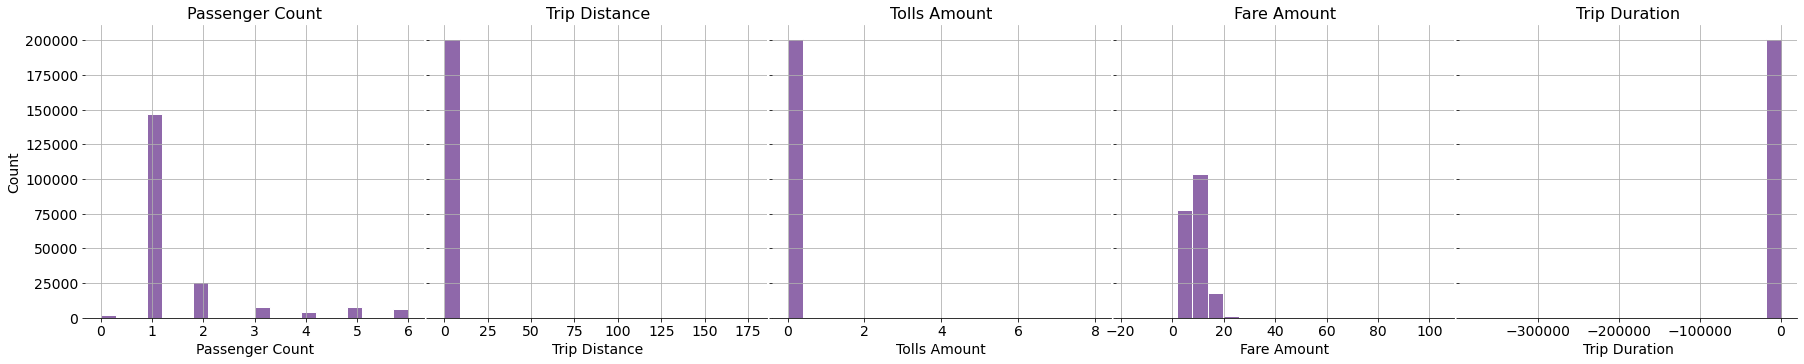

In [50]:
# Display histograms of numerical columns
plot_histplot(
    train_sub_df, num_cols, num_colnames, ncols=len(num_cols), color="#602887"
)

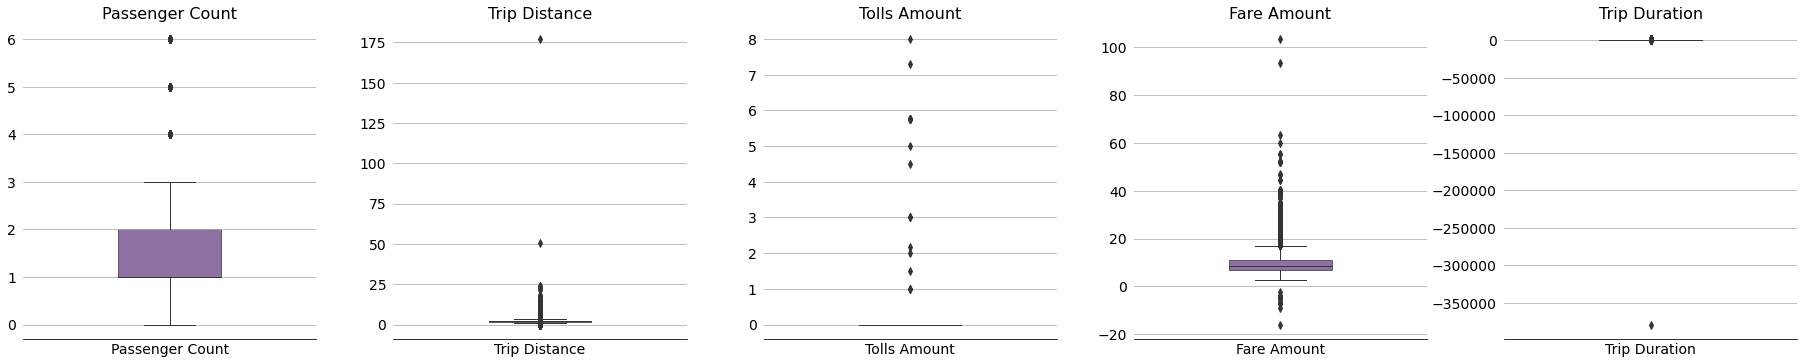

In [51]:
# Display boxplots of numerical columns
plot_boxplot(train_sub_df, num_cols, num_colnames, ncols=len(num_cols), color="#602887")

In [52]:
# Compute the numerical columns' 75, 95, and 99th percentiles
percentiles_sub_df = train_sub_df.quantile([0.75, 0.95, 0.99])[num_cols].reset_index()

# Display the numerical columns' 75, 95, and 99th percentiles
percentiles_sub_df

,index,passenger_count,trip_distance,tolls_amount,fare_amount,trip_duration
0,0.75,2.0,2.414010,0.0,11.0,16.0
1,0.95,5.0,2.896812,0.0,15.5,25.0
2,0.99,6.0,3.331334,0.0,19.0,33.0


In [53]:
# Remove outliers from the train dataset
train_sub_df = remove_outliers(train_sub_df, percentiles_sub_df)

# Remove outliers from the test dataset
test_sub_df = remove_outliers(test_sub_df, percentiles_sub_df)

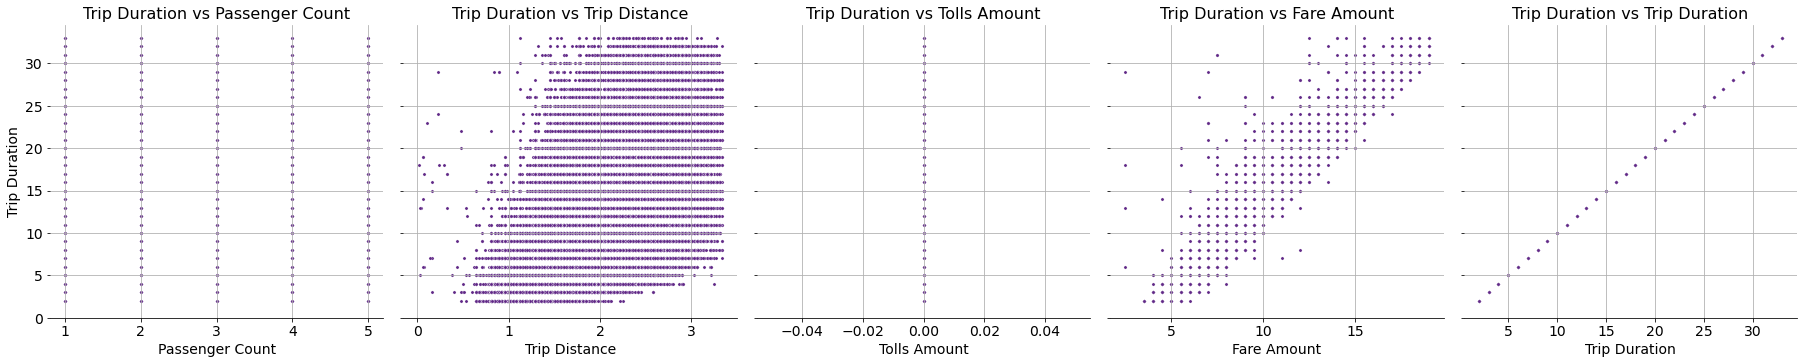

In [54]:
# Display scatterplot of numerical columns
plot_scatter(
    train_sub_df,
    num_cols,
    num_colnames,
    "trip_duration",
    ncols=len(num_cols),
    color="#602887",
)

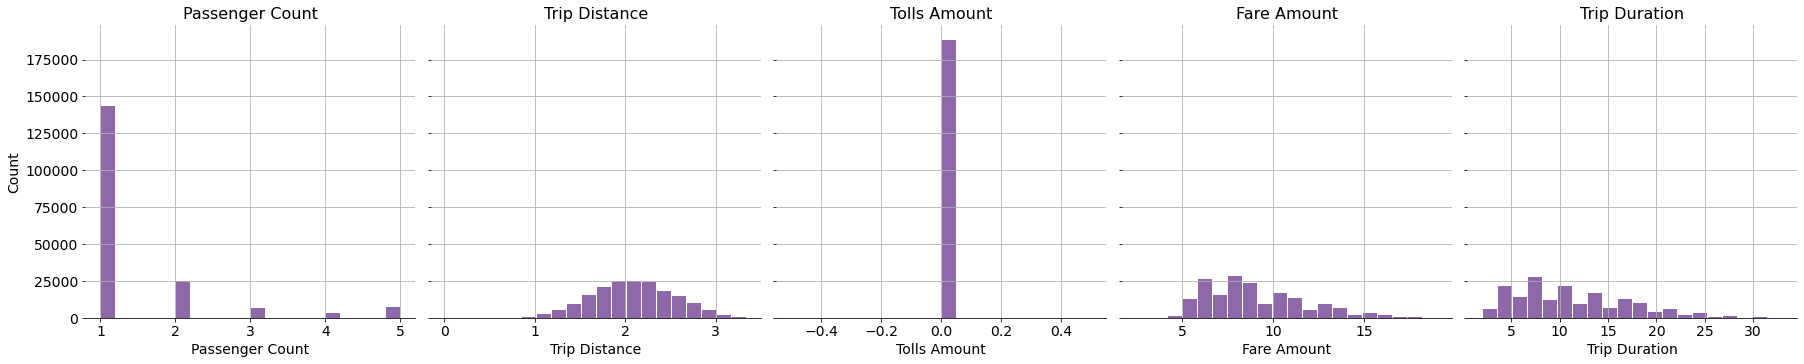

In [55]:
# Display histograms of numerical columns
plot_histplot(
    train_sub_df, num_cols, num_colnames, ncols=len(num_cols), color="#602887"
)

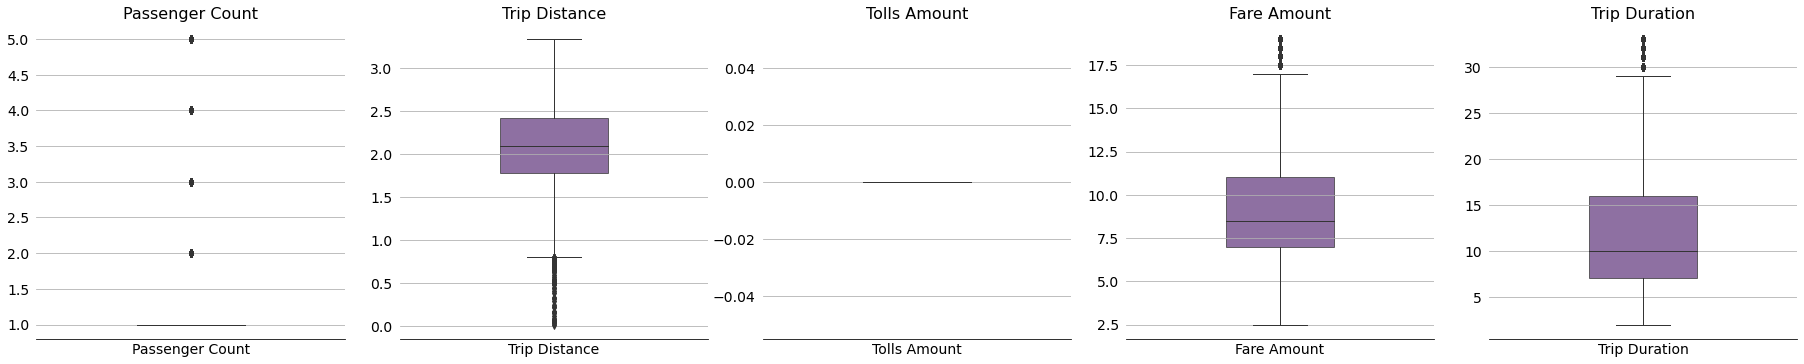

In [56]:
# Display boxplots of numerical columns
plot_boxplot(train_sub_df, num_cols, num_colnames, ncols=len(num_cols), color="#602887")

### Taxi Trips Subset: Feature Engineering

In [57]:
# Add features to the train data frame
train_sub_df = add_features(train_sub_df)

# Add features to the test data frame
test_sub_df = add_features(test_sub_df)

# Display a quick description of the data frame
train_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189067 entries, 232460 to 199340
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   pickup_datetime      189067 non-null  datetime64[ns]
 1   dropoff_datetime     189067 non-null  datetime64[ns]
 2   passenger_count      189067 non-null  int64         
 3   trip_distance        189067 non-null  float64       
 4   tolls_amount         189067 non-null  float64       
 5   fare_amount          189067 non-null  float64       
 6   pickup_location_id   189067 non-null  int64         
 7   dropoff_location_id  189067 non-null  int64         
 8   trip_duration        189067 non-null  float64       
 9   pickup_date          189067 non-null  datetime64[ns]
 10  pickup_month         189067 non-null  int64         
 11  pickup_week          189067 non-null  UInt32        
 12  pickup_yearday       189067 non-null  int64         
 13  pickup_we

In [58]:
# Add the external dataset to the train data frame
train_sub_df = add_datasets(train_sub_df, weather_df, holidays_df, zones_df)

# Add the external dataset to the test data frame
test_sub_df = add_datasets(test_sub_df, weather_df, holidays_df, zones_df)

# Display a quick description of the data frame
train_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189067 entries, 0 to 189066
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   passenger_count            189067 non-null  int64  
 1   trip_distance              189067 non-null  float64
 2   tolls_amount               189067 non-null  float64
 3   fare_amount                189067 non-null  float64
 4   pickup_location_id         189067 non-null  int64  
 5   dropoff_location_id        189067 non-null  int64  
 6   trip_duration              189067 non-null  float64
 7   pickup_month               189067 non-null  int64  
 8   pickup_week                189067 non-null  UInt32 
 9   pickup_yearday             189067 non-null  int64  
 10  pickup_weekday             189067 non-null  int64  
 11  pickup_weekday_type        189067 non-null  int64  
 12  pickup_hour                189067 non-null  int64  
 13  pickup_hour_type           18

In [59]:
# Fill missing values from the train dataset with 0
train_sub_df = train_sub_df.fillna(0)

# Fill missing values from the test dataset with 0
test_sub_df = test_sub_df.fillna(0)

# Display a quick description of the data frame
train_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189067 entries, 0 to 189066
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   passenger_count            189067 non-null  int64  
 1   trip_distance              189067 non-null  float64
 2   tolls_amount               189067 non-null  float64
 3   fare_amount                189067 non-null  float64
 4   pickup_location_id         189067 non-null  int64  
 5   dropoff_location_id        189067 non-null  int64  
 6   trip_duration              189067 non-null  float64
 7   pickup_month               189067 non-null  int64  
 8   pickup_week                189067 non-null  UInt32 
 9   pickup_yearday             189067 non-null  int64  
 10  pickup_weekday             189067 non-null  int64  
 11  pickup_weekday_type        189067 non-null  int64  
 12  pickup_hour                189067 non-null  int64  
 13  pickup_hour_type           18

In [60]:
# Create a new column indicating if the trip was within the same borough
train_sub_df["trip_within_borough"] = np.where(
    train_sub_df["pickup_borough_id"] == train_sub_df["dropoff_borough_id"], 1, 0
)

# Create a new column indicating if the trip was within the same borough
test_sub_df["trip_within_borough"] = np.where(
    test_sub_df["pickup_borough_id"] == test_sub_df["dropoff_borough_id"], 1, 0
)

# Display a quick description of the data frame
train_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189067 entries, 0 to 189066
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   passenger_count            189067 non-null  int64  
 1   trip_distance              189067 non-null  float64
 2   tolls_amount               189067 non-null  float64
 3   fare_amount                189067 non-null  float64
 4   pickup_location_id         189067 non-null  int64  
 5   dropoff_location_id        189067 non-null  int64  
 6   trip_duration              189067 non-null  float64
 7   pickup_month               189067 non-null  int64  
 8   pickup_week                189067 non-null  UInt32 
 9   pickup_yearday             189067 non-null  int64  
 10  pickup_weekday             189067 non-null  int64  
 11  pickup_weekday_type        189067 non-null  int64  
 12  pickup_hour                189067 non-null  int64  
 13  pickup_hour_type           18

### Taxi Trips Subset: Feature Binning

In [61]:
# Create a new column of binned tolls amounts in the train dataset
train_sub_df["tolls_amount"] = train_sub_df["tolls_amount"].apply(
    lambda x: 0 if x == 0 else (1 if x < 3 else 2)
)

# Create a new column of binned tolls amounts in the test dataset
test_sub_df["tolls_amount"] = test_sub_df["tolls_amount"].apply(
    lambda x: 0 if x == 0 else (1 if x < 3 else 2)
)

# Display the first five rows of the data frame
train_sub_df.head()

,passenger_count,trip_distance,tolls_amount,fare_amount,pickup_location_id,dropoff_location_id,trip_duration,pickup_month,pickup_week,pickup_yearday,...,pickup_zone_latitude,pickup_zone_longitude,pickup_borough_latitude,pickup_borough_longitude,dropoff_borough_id,dropoff_zone_latitude,dropoff_zone_longitude,dropoff_borough_latitude,dropoff_borough_longitude,trip_within_borough
0,1,2.188702,0,9.5,186,161,13.0,3,9,63,...,4.975315e+06,-8.236800e+06,4.979599e+06,-8.233970e+06,3,4.976716e+06,-8.235160e+06,4.979599e+06,-8.233970e+06,1
1,1,1.915115,0,13.5,186,161,21.0,11,44,306,...,4.975315e+06,-8.236800e+06,4.979599e+06,-8.233970e+06,3,4.976716e+06,-8.235160e+06,4.979599e+06,-8.233970e+06,1
2,1,2.896812,0,11.0,186,161,15.0,8,35,239,...,4.975315e+06,-8.236800e+06,4.979599e+06,-8.233970e+06,3,4.976716e+06,-8.235160e+06,4.979599e+06,-8.233970e+06,1
3,1,1.770274,0,7.0,186,161,6.0,8,33,229,...,4.975315e+06,-8.236800e+06,4.979599e+06,-8.233970e+06,3,4.976716e+06,-8.235160e+06,4.979599e+06,-8.233970e+06,1
4,5,2.912905,0,9.5,186,161,10.0,6,23,155,...,4.975315e+06,-8.236800e+06,4.979599e+06,-8.233970e+06,3,4.976716e+06,-8.235160e+06,4.979599e+06,-8.233970e+06,1


In [62]:
# Drop other columns from the train data frame
train_sub_df.drop(
    columns=["passenger_count", "fare_amount"], inplace=True
)

# Drop other columns from the test data frame
test_sub_df.drop(
    columns=["passenger_count", "fare_amount"], inplace=True
)

# Display a quick description of the data frame
train_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189067 entries, 0 to 189066
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   trip_distance              189067 non-null  float64
 1   tolls_amount               189067 non-null  int64  
 2   pickup_location_id         189067 non-null  int64  
 3   dropoff_location_id        189067 non-null  int64  
 4   trip_duration              189067 non-null  float64
 5   pickup_month               189067 non-null  int64  
 6   pickup_week                189067 non-null  UInt32 
 7   pickup_yearday             189067 non-null  int64  
 8   pickup_weekday             189067 non-null  int64  
 9   pickup_weekday_type        189067 non-null  int64  
 10  pickup_hour                189067 non-null  int64  
 11  pickup_hour_type           189067 non-null  int64  
 12  avg_temp                   189067 non-null  int64  
 13  prec                       18

### Taxi Trips Subset: Preliminary Data Analysis

In [63]:
train_sub_df["trip_distance"].median()

2.092142

In [64]:
train_sub_df["trip_duration"].median()

10.0

***
## Data Export

In [65]:
# Export the train data frame as a pickle file
train_df.to_pickle(r'data/processed/train.pickle')

# Export the test data frame as a pickle file
test_df.to_pickle(r'data/processed/test.pickle')

# Export the sub train data frame as a pickle file
train_sub_df.to_pickle(r'data/processed/train_sub.pickle')

# Export the sub test data frame as a pickle file
test_sub_df.to_pickle(r'data/processed/test_sub.pickle')